In [2]:
import json
import pandas as pd
data_file = open("/Users/mike/Desktop/INF2290/yelp_academic_dataset_review.json")
data = []
i=0
for line in data_file:
    data.append(json.loads(line))
    i+=1
    if i ==100000:
        break
df = pd.DataFrame(data)
data_file.close()

In [3]:
### Data pre-processing ###

In [4]:
import re 

### remove punctuation ###

df["processed_text"] = df['text'].str.replace('[^\w\s]','')

### convert uppercase to lowercase letters ###

df['processed_text'] = \
df['processed_text'].map(lambda x: x.lower())

### remove columns ###

df = df.drop(columns = ['review_id', 'user_id', 'business_id', 'useful', 'funny', 'cool', 'text', 'date'])

/var/folders/vn/snkbxk1s7w14425jjpssy9lc0000gn/T/ipykernel_64765/247609051.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df["processed_text"] = df['text'].str.replace('[^\w\s]','')


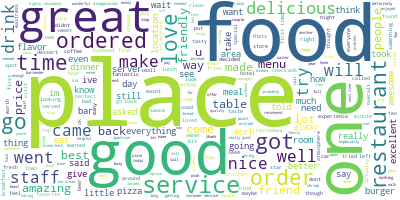

In [5]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df['processed_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [6]:
three_star_reviews = df[df['stars'] == 3]

In [7]:
### LDA ###

In [8]:
import gensim
import nltk
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel

In [9]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'wow', 'went', 'now', 'got', 'ive', 'rlwhzyisbhwa', 'review_id', 
                  'user_id', 'business_id'])

def sent_word(sentence): 
    for sentence in sentence:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_words(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = three_star_reviews.processed_text.values.tolist()
data_words = list(sent_word(data))

data_words = remove_words(data_words)

print(data_words[:1])

[['decide', 'eat', 'aware', 'going', 'take', 'hours', 'beginning', 'end', 'tried', 'multiple', 'times', 'want', 'like', 'locations', 'nj', 'never', 'bad', 'experience', 'food', 'good', 'takes', 'long', 'time', 'come', 'waitstaff', 'young', 'usually', 'pleasant', 'many', 'experiences', 'spent', 'way', 'long', 'waiting', 'usually', 'opt', 'another', 'diner', 'restaurant', 'weekends', 'order', 'done', 'quicker']]


In [10]:
import gensim.corpora as corpora

id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [11]:
def LDA(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = num_topics, random_state = 100, 
                                               chunksize = 200, passes = 10, per_word_topics = True, id2word = id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [12]:
model_list, coherence_values = LDA(dictionary = id2word, 
                                   corpus = corpus, 
                                   texts = texts,
                                   start = 2, 
                                   limit = 10, 
                                   step =1)

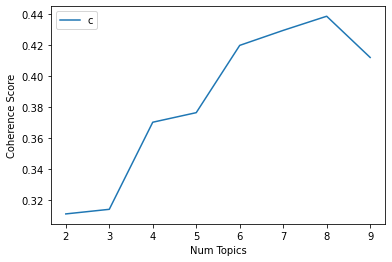

In [13]:
import pyLDAvis 
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt 



limit = 10; start = 2; step = 1;
model1 = range(start, limit, step)
plt.plot(model1, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_values"), loc = 'best')
plt.show()

In [14]:
from pprint import pprint

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.032*"chicken" + 0.029*"ordered" + 0.024*"cheese" + 0.024*"salad" + '
  '0.023*"burger" + 0.023*"fries" + 0.021*"sauce" + 0.016*"flavor" + '
  '0.015*"fried" + 0.014*"sweet"'),
 (1,
  '0.018*"find" + 0.018*"location" + 0.016*"parking" + 0.013*"selection" + '
  '0.013*"store" + 0.011*"outside" + 0.011*"lot" + 0.010*"street" + '
  '0.009*"liked" + 0.009*"open"'),
 (2,
  '0.032*"wings" + 0.022*"car" + 0.018*"tour" + 0.017*"donuts" + 0.016*"park" '
  '+ 0.012*"issues" + 0.012*"asian" + 0.012*"play" + 0.012*"american" + '
  '0.011*"hair"'),
 (3,
  '0.022*"wine" + 0.020*"music" + 0.020*"crab" + 0.016*"return" + '
  '0.015*"coming" + 0.014*"beers" + 0.012*"bartender" + 0.012*"seafood" + '
  '0.011*"near" + 0.011*"sunday"'),
 (4,
  '0.021*"good" + 0.019*"food" + 0.015*"place" + 0.012*"like" + 0.010*"great" '
  '+ 0.009*"one" + 0.009*"would" + 0.009*"get" + 0.009*"service" + '
  '0.009*"really"'),
 (5,
  '0.069*"pizza" + 0.025*"tea" + 0.024*"kids" + 0.015*"giving" + 0.014*"kinda" '
  '

In [15]:
perplexity = lda_model.log_perplexity(corpus)

In [23]:
# lower the score the better #
print(perplexity)

-8.287139689749


In [24]:
# coherence #
cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-4.129107944016541


In [17]:
### CorEx ###

In [18]:
import numpy as np
import scipy.sparse as ss
from corextopic import corextopic as ct

# Define a matrix where rows are samples (docs) and columns are features (words)
X = np.array([[0,0,0,1,1],
              [1,1,1,0,0],
              [1,1,1,1,1]], dtype=int)
# Sparse matrices are also supported
X = ss.csr_matrix(X)
# Word labels for each column can be provided to the model
words = ['dog', 'cat', 'fish', 'apple', 'orange']
# Document labels for each row can be provided
docs = ['fruit doc', 'animal doc', 'mixed doc']

# Train the CorEx topic model
topic_model = ct.Corex(n_hidden=2)  # Define the number of latent (hidden) topics to use.
topic_model.fit(X, words=words, docs=docs)

In [19]:
### BTM ###

from biterm.utility import vec_to_biterms
from biterm.cbtm import oBTM
from biterm.btm import oBTM

/var/folders/vn/snkbxk1s7w14425jjpssy9lc0000gn/T/ipykernel_64039/3164096841.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from biterm.cbtm import oBTM


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

texts = open('/Users/mike/Desktop/INF2290/yelp_academic_dataset_review.json').read().splitlines()[:50]
vec = CountVectorizer(stop_words='english')
X = vec.fit_transform(texts).toarray()

KeyboardInterrupt: 

In [25]:
### NNMF ###

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text

from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

In [16]:
pd.set_option('display.max_colwidth', -1)
df.head(20)

/var/folders/vn/snkbxk1s7w14425jjpssy9lc0000gn/T/ipykernel_64765/4062793696.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


stars  \
0   3.0     
1   5.0     
2   3.0     
3   5.0     
4   4.0     
5   1.0     
6   5.0     
7   5.0     
8   3.0     
9   3.0     
10  5.0     
11  4.0     
12  4.0     
13  4.0     
14  4.0     
15  5.0     
16  5.0     
17  4.0     
18  5.0     
19  5.0     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    processed_text  
0   if you decide to eat here just be aware it is going to take about 2 hours from beginning to end we have tried it multiple times because i want to like it i have been to its other locations in nj and never had a bad experience \n\nthe food is good but it takes a very long time to come out the waitstaff is very young but usually pleasant we have just had too many experiences where we spent way too long waiting we usually opt for another diner or restaurant on the weekends in order to be done quicker                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1   ive taken a lot of spin classes over the years and nothing compares to the classes at body cycle from the nice clean space and amazing bikes to the welcoming and motivating instructors every class is a top notch work out\n\nfor anyone who struggles to fit workouts in the online scheduling system makes it easy to plan ahead and theres no need to line up way in advanced like many gyms make you do\n\nthere is no way i can write this review without giving russell the owner of body cycle a shout out russells passion for fitness and cycling is so evident as is his desire for all of his clients to succeed he is always dropping in to classes to check inprovide encouragement and is open to ideas and recommendations from anyone russell always wears a smile on his face even when hes kicking your butt in class                                                                                                                                                                                       
2   family diner had the buffet eclectic assortment a large chicken leg fried jalapeño tamale two rolled grape leaves fresh melon all good lots of mexican choices there also has a menu with breakfast served all day long friendly attentive staff good place for a casual relaxed meal with no expectations next to the clarion hotel                                                                                                                                                                                                                                                                                                                                                                                                                           

In [33]:
df = df[df['stars'] == 3]

In [40]:
df = df.drop_duplicates(subset=['processed_text'], keep='first')

In [44]:
df.head()

processed_text
stars                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
3.0    if you decide to eat here just be aware it is going to take about   hours from beginning to end we have tried it multiple times because i want to like it i have been to its other locations in nj and never had a bad experience \n\nthe food is good but it takes a very long time to come out the waitstaff is very young but usually pleasant we have just had too many experiences where we spent way too long waiting we usually opt for another diner or restaurant on the weekends in order to be done quicker                                                                                                                                                                                                                         
3.0    family diner had the buffet eclectic assortment a large chicken leg fried jalapeño tamale two rolled grape leaves fresh melon all good lots of mexican choices there also has a menu with breakfast served all day long friendly attentive staff good place for a casual relaxed meal with no expectations next to the clarion hotel                                                                                                                                                                                                                                                                                                                                                                                                           
3.0    this easter instead of going to lopez lake we went to los padres national forest which is really pretty but if you go to white rock the staff needs to cut down all the dead grass that invades the rock and the water i would wish the staff would also clean or get rid of the dead grass thats also living by the water the water is really green and dirty los padres national forest staff need to work hard to maintain this forest looking pretty and not like a dumpster even cachuma lake looks like they put a bit more effort                                                                                                                                                                                                       
3.0    had a party of   here for hibachi our waitress brought our separate sushi orders on one plate so we couldnt really tell whos was whos and forgot several items on an order i understand making mistakes but the restaraunt was really quiet so we were kind of surprised usually hibachi is a fun lively experience and our  cook  said maybe three words but he cooked very well his name was francisco service was fishy food was pretty good and im hoping it was just an off night here but for the money i wouldnt go back                                                                                                                                                                                                                
3.0    upland is a brewery based out of bloomington indiana that has become popular enough to open up a couple additional locations in central indiana  all of their beers are very good and i am also a fan of their burgers and tenderloins  therefore i was excited to try their pizza but i dont think it ended up being on par with these other items  my

In [42]:
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, 
    remove punctuation, remove read errors,
    and remove words containing numbers.'''    
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('�', ' ', text)    
    
    return text

<>:8: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \[
<>:10: DeprecationWarning: invalid escape sequence \w
/var/folders/vn/snkbxk1s7w14425jjpssy9lc0000gn/T/ipykernel_64039/1069715493.py:8: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', ' ', text)
/var/folders/vn/snkbxk1s7w14425jjpssy9lc0000gn/T/ipykernel_64039/1069715493.py:10: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', ' ', text)


In [1]:
round1 = lambda x: clean_text_round1(x)

# Clean Speech Text
df["processed_text"] = df["processed_text"].apply(round1)

# Visually Inspect
df.head(20)

NameError: name 'df' is not defined

In [38]:
def nouns(text):
    #Given a string of text, tokenize the text 
    #and pull out only the nouns.   
    
    # create mask to isolate words that are nouns
    is_noun = lambda pos: pos[:2] == 'NN'    
    
    # store function to split string of words 
    # into a list of words (tokens)
    tokenized = word_tokenize(text)    
    
    # store function to lemmatize each word
    wordnet_lemmatizer = WordNetLemmatizer()    
    
    # use list comprehension to lemmatize all words 
    # and create a list of all nouns
    all_nouns = [wordnet_lemmatizer.lemmatize(word) \
    for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    
    #return string of joined list of nouns
    return ' '.join(all_nouns)

# Create dataframe of only nouns from speeches
data_nouns = pd.DataFrame(df.processed_text.apply(nouns))

# Visually Inspect
data_nouns.head()

processed_text
0   hour time i location nj experience food time waitstaff experience way diner restaurant weekend order quicker                                                                                                                                     
2   family diner buffet assortment chicken leg grape melon lot choice menu breakfast day staff place relaxed meal expectation clarion hotel                                                                                                          
8   easter lake padre forest rock staff grass rock water i staff grass thats water water los padre staff need dumpster look bit effort                                                                                                               
9   party waitress sushi order plate who item order i mistake restaraunt kind fun experience cook word name service food night money i                                                                                                               
21  upland brewery bloomington indiana location indiana beer fan burger tenderloin i pizza dont par item pizza crackerlike crust cheese none topping flavor sauce margherita pizza opinion upland appetizer group burger tenderloin meal choice visit

In [ ]:
data_nouns.head()

In [ ]:
# Add additional stop words since we are recreating the document-term matrix
stop_noun = ["america", 'today', 'thing']
stop_words_noun_agg = text.ENGLISH_STOP_WORDS.union(stop_noun)

# Create a document-term matrix with only nouns

# Store TF-IDF Vectorizer
tv_noun = TfidfVectorizer(stop_words=stop_words_noun_agg, ngram_range = (1,1), max_df = .8, min_df = .01)


# Fit and Transform speech noun text to a TF-IDF Doc-Term Matrix
data_tv_noun = tv_noun.fit_transform(data_nouns.processed_text)

# Create data-frame of Doc-Term Matrix with nouns as column names
data_dtm_noun = pd.DataFrame(data_tv_noun.toarray(), columns=tv_noun.get_feature_names())

# Set President's Names as Index
data_dtm_noun.index = df.index

# Visually inspect Document Term Matrix
data_dtm_noun.head()

In [ ]:
def display_topics(model, feature_names, num_top_words,topic_names=None):
#'''Given an NMF model, feature_names, and number of top words, print topic number 
#and its top feature names, up to specified number of top words.'''    
    
    # iterate through topics in topic-term matrix, 'H' aka
    # model.components_
    for ix, topic in enumerate(model.components_):        
        
        #print topic, topic number, and top words
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [ ]:
nmf_model = NMF(2)

# Learn an NMF model for given Document Term Matrix 'V' 
# Extract the document-topic matrix 'W'
doc_topic = nmf_model.fit_transform(data_dtm_noun)

# Extract top words from the topic-term matrix 'H' 
display_topics(nmf_model, tv_noun.get_feature_names(), 5)

In [ ]:
nmf_model = NMF(8)
doc_topic = nmf_model.fit_transform(data_dtm_noun)
display_topics(nmf_model, tv_noun.get_feature_names(), 5)

In [17]:
pd.set_option('display.max_colwidth', -1)
df.head(20)

/var/folders/vn/snkbxk1s7w14425jjpssy9lc0000gn/T/ipykernel_64765/4062793696.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


stars  \
0   3.0     
1   5.0     
2   3.0     
3   5.0     
4   4.0     
5   1.0     
6   5.0     
7   5.0     
8   3.0     
9   3.0     
10  5.0     
11  4.0     
12  4.0     
13  4.0     
14  4.0     
15  5.0     
16  5.0     
17  4.0     
18  5.0     
19  5.0     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    processed_text  
0   if you decide to eat here just be aware it is going to take about 2 hours from beginning to end we have tried it multiple times because i want to like it i have been to its other locations in nj and never had a bad experience \n\nthe food is good but it takes a very long time to come out the waitstaff is very young but usually pleasant we have just had too many experiences where we spent way too long waiting we usually opt for another diner or restaurant on the weekends in order to be done quicker                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1   ive taken a lot of spin classes over the years and nothing compares to the classes at body cycle from the nice clean space and amazing bikes to the welcoming and motivating instructors every class is a top notch work out\n\nfor anyone who struggles to fit workouts in the online scheduling system makes it easy to plan ahead and theres no need to line up way in advanced like many gyms make you do\n\nthere is no way i can write this review without giving russell the owner of body cycle a shout out russells passion for fitness and cycling is so evident as is his desire for all of his clients to succeed he is always dropping in to classes to check inprovide encouragement and is open to ideas and recommendations from anyone russell always wears a smile on his face even when hes kicking your butt in class                                                                                                                                                                                       
2   family diner had the buffet eclectic assortment a large chicken leg fried jalapeño tamale two rolled grape leaves fresh melon all good lots of mexican choices there also has a menu with breakfast served all day long friendly attentive staff good place for a casual relaxed meal with no expectations next to the clarion hotel                                                                                                                                                                                                                                                                                                                                                                                                                           

In [20]:
df1 = df[df['stars'] == 1]
df2 = df[df['stars'] == 2]
df3 = df[df['stars'] == 3]
df4 = df[df['stars'] == 4]
df5 = df[df['stars'] == 5]

In [21]:
df1.head(5)

stars  \
5   1.0     
47  1.0     
64  1.0     
73  1.0     
79  1.0     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  processed_text  
5   i am a long term frequent customer of this establishment i just went in to order take out 3 apps and was told theyre too busy to do it really the place is maybe half full at best does your dick reach your ass yes go fuck yourself im a frequent customer and great tipper glad that kanella just opened never going back to dmitris                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
47  if you want to pay for everything a la carte this is the place for you  \nfood wasnt terrible not impressive\nthey brought a basket of chips and some tomato sauce which i asked politely for something spicier and some pico de gallo  she brought them happily to me and the salsa was much better  when asked what we would like to drink i asked for a coke and she brought out a bottle which i stated i wanted the fountain drink  she said oh thats only pepsi  never mentioned that they only had bottle drinks for coke  \nwe ordered our food which was reasonably priced asked for sour cream and also to put cheese on the taco  she let us know cheese was extra  \nit was 250 extra for another basket of chips  \nwhen i received the bill we paid more for the condiments then the actual food  side of sour cream 200 pico de gallo 250 salsa 200 chips 250 cheese 100 and the bottled coke that we didnt want 500  \njust a suggestionwhen you order anything make sure to ask if there is an extra charge  
64  the tv shows are 499 and they have commercials what a cheesy way to make money and a sign of a less than classy hotel particularly when you pay more than 150 a night  and there is no complimentary breakfast just an overpriced buffet something even the cheapest hotels in california provide                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [22]:
df2.head(5)

stars  \
29  2.0     
41  2.0     
46  2.0     
50  2.0     
85  2.0     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 processed_text  
29  i at least have to give this restaurant two stars due to the decent food but while on a dinner meeting and after spending 100 on entrées and appetizers i had to flag down the assistant cook the guy in bright red baggy pants watching tv to see if i could get more avocado for my tuna entrée  he made it very apparent and direct that he could not help me with that situation and i would have to flag down my  waitress so she could bill me for the four dollar avocado                                                                                                                                                                                                                                                                                                                                                                             
41  straight to the point its cheap it tastes and feels cheap\n\nthe good price location dessert edible food items are baked chicken fried chicken mashed potatoes salad bar lol meat and cheese bar ravioli pizza also our waitress was bomb af\n\nthe meh behind counter meat slicing station shrimp not even deveined mexican station\n\nthe bad breakfast worst eggs ever actually worst eggs le benedict cant even cut through ham or english muffin tried on all 3 occasions steak shrimp again hell breaded items cant even dont even decor its the 1970 nightmare you can imagine\n\ntried 3 times and failed                                                                                                                                                                                                                                            
46  never again this is a so called restaurant that does nothing that a restaurant should other than prepare food because the rest is done by the patron want water get up and go across the yard to get it want a drink walk up a flight of stairs and pay cash want to sit in a dirty yard in dirty lawn chairs enjoy yourself the wait staff is mildy helpful in that they bring you your food after you go to the window and pay cash for itkind of like new orleans hamburger and seafood but dirty and with live music which is nice its a one in a lifetime experience for mejust once                                                                                                                                                                                                                                                                    
50  we started with the artichoke dip big mistake it was cold and the chips were stale mentioned to our waitress but nothing came of it  we ordered a large pizza thin crust which after adding toppings it was a bit pricey for pizza  pizza was ok not great except for not being our advocate our server was good  i have been here before for cardinals game it was better then will try another venue next time                                                                                                                                                                                         

In [23]:
df3.head(5)

stars  \
0   3.0     
2   3.0     
8   3.0     
9   3.0     
21  3.0     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     processed_text  
0   if you decide to eat here just be aware it is going to take about 2 hours from beginning to end we have tried it multiple times because i want to like it i have been to its other locations in nj and never had a bad experience \n\nthe food is good but it takes a very long time to come out the waitstaff is very young but usually pleasant we have just had too many experiences where we spent way too long waiting we usually opt for another diner or restaurant on the weekends in order to be done quicker                                                                                                                                                                                                                           
2   family diner had the buffet eclectic assortment a large chicken leg fried jalapeño tamale two rolled grape leaves fresh melon all good lots of mexican choices there also has a menu with breakfast served all day long friendly attentive staff good place for a casual relaxed meal with no expectations next to the clarion hotel                                                                                                                                                                                                                                                                                                                                                                                                             
8   this easter instead of going to lopez lake we went to los padres national forest which is really pretty but if you go to white rock the staff needs to cut down all the dead grass that invades the rock and the water i would wish the staff would also clean or get rid of the dead grass thats also living by the water the water is really green and dirty los padres national forest staff need to work hard to maintain this forest looking pretty and not like a dumpster even cachuma lake looks like they put a bit more effort                                                                                                                                                                                                         
9   had a party of 6 here for hibachi our waitress brought our separate sushi orders on one plate so we couldnt really tell whos was whos and forgot several items on an order i understand making mistakes but the restaraunt was really quiet so we were kind of surprised usually hibachi is a fun lively experience and our  cook  said maybe three words but he cooked very well his name was francisco service was fishy food was pretty good and im hoping it was just an off night here but for the money i wouldnt go back                                                                                                                                                                                                                  
21  upland is a brewery based out of bloomington indiana that has become popular enough to open up a couple additional locations in central indiana  all of their beers are very good and i am also a fan of their burgers and tenderloins  therefore i was excited to try their pizza but i dont think

In [24]:
df4.head(5)

stars  \
4   4.0     
11  4.0     
12  4.0     
13  4.0     
14  4.0     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   processed_text  
4   cute interior and owner  gave us tour of upcoming patiorooftop area which will be great on beautiful days like today cheese curds were very good and very filling really like that sandwiches come w salad esp after eating too many curds had the onion gruyere tomato sandwich wasnt too much cheese which i liked needed something elsepepper jelly maybe would like to see more menu options added such as salads w fun cheeses lots of beer and wine as well as limited cocktails next time i will try one of the draft wines                                                                                                                             
11  locals recommended milktooth and its an amazing jewel of indianapolis im glade i had the chance to experience this                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
12  love going here for happy hour or dinner  great patio with fans to beat the stl heat   alsovery accomodating at this location  i like the veal milanese but with mixed greens instead of pasta  theyll modify the menu to suit your taste                                                                                                                                                                                                                                                                                                                                                                                                                      
13  good foodloved the gnocchi with marinara\nthe baked eggplant appetizer was very good too\n\nthe service was very slow but despite this id go back the food is just that good                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
14  the bun makes the sonoran dog its like a snuggie for the pup a first it seems ridiculous and almost like its going to be too much exactly like everyones favorite blanket with sleeves too much softness too much smush too indulgent  wrong its warm soft chewy fragrant and it succeeds where other famed sonoran dogs fail \n\nthe hot dog itself is flavorful but i would prefer that it or the bacon have a little more bite or snap to better hold their own against the dominant mustard and onions \n\nim with the masses on the carne asada caramelo excellent tortilla salty melty cheese and great carne \n\nsuper cheap and you can drive through

In [25]:
df5.head(5)

stars  \
1   5.0     
3   5.0     
6   5.0     
7   5.0     
10  5.0     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    processed_text  
1   ive taken a lot of spin classes over the years and nothing compares to the classes at body cycle from the nice clean space and amazing bikes to the welcoming and motivating instructors every class is a top notch work out\n\nfor anyone who struggles to fit workouts in the online scheduling system makes it easy to plan ahead and theres no need to line up way in advanced like many gyms make you do\n\nthere is no way i can write this review without giving russell the owner of body cycle a shout out russells passion for fitness and cycling is so evident as is his desire for all of his clients to succeed he is always dropping in to classes to check inprovide encouragement and is open to ideas and recommendations from anyone russell always wears a smile on his face even when hes kicking your butt in class                                                                                                                                                                                       
3   wow  yummy different  delicious   our favorite is the lamb curry and korma  with 10 different kinds of naan  dont let the outside deter you because we almost changed our mindsgo in and try something new   youll be glad you did                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
6   loved this tour i grabbed a groupon and the price was great it was the perfect way to explore new orleans for someone whod never been there before and didnt know a lot about the history of the city our tour guide had tons of interesting tidbits about the city and i really enjoyed the experience highly recommended tour i actually thought we were just going to tour through the cemetery but she took us around the french quarter for the first hour and the cemetery for the second half of the tour youll meet up in front of a grocery store seems strange at first but its not terribly hard to find and itll give you a chance to get some water and youll stop at a visitor center part way through the tour for a bathroom break if needed this tour was one of my favorite parts of my trip                                                                                                                                                    